In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import mdtraj as md

In [2]:
def calc_NHVecs(traj_file, top_file, start_snap=0, end_snap=-1):
    """
    Uses mdtraj to load the trajectory and get the atomic indices and coordinates to calculate the correlation functions.
    For each, trajectory load the trajectory using mdtraj, get the atomic index for the the N-H atoms and calculate the vector between the two.
    Append the vector to the NHVecs list for all the trajectories. 
    NHVecs should return a list of shape: (# Trajectories, # Snapshots, # Residues w/N-H Vectors, 3)
    """
    traj = md.load(traj_file, top=top_file)
    top = traj.topology
    
    ##AtomSelection Indices
    Nit = top.select('name N and not resname PRO') ## PRO residue do not have N-H vectors
    Hyd = top.select('name H and not resname PRO')
    NH_Pair = [[i,j] for i,j in zip(Nit,Hyd)]
    NH_Pair_Name = [[top.atom(i),top.atom(j)] for i,j in NH_Pair]
    NH_Res = ["{}-{}{}".format(str(i).split('-')[0],str(i).split('-')[1], str(j).split('-')[1]) for i,j in NH_Pair_Name]
    
    ##Generate the N-H vectors in Laboratory Frame
    NHVecs_tmp = np.take(traj.xyz, Hyd, axis=1) - np.take(traj.xyz, Nit, axis=1)
    sh = list(NHVecs_tmp.shape)
    sh[2] = 1
    NHVecs_tmp = NHVecs_tmp / np.linalg.norm(NHVecs_tmp, axis=2).reshape(sh)
    
    return NHVecs_tmp[start_snap:end_snap]

In [3]:
def split_NHVecs(nhvecs, dt, tau):
    """
    This function will split the trajectory in chunks defined by tau. 
    nhvecs = array of N-H bond vectors,
    dt = timestep of the simulation
    tau = length of chunks
    """
    nFiles = len(nhvecs) ## number of trajectories
    nFramesPerChunk = int(tau/dt) ###tau/timestep 
    used_frames = np.zeros(nFiles,dtype=int)
    remainingFrames = np.zeros(nFiles,dtype=int)
    for i in range(nFiles):
        nFrames = nhvecs[i].shape[0]
        used_frames[i] = int(nFrames/nFramesPerChunk)*nFramesPerChunk
        remainingFrames[i] = nFrames % nFramesPerChunk
    
    nFramesTot=int(used_frames.sum())
    out = np.zeros((nFramesTot,NHVecs[0].shape[1],NHVecs[0].shape[2]), dtype=NHVecs[0].dtype)
    start = 0
    for i in range(nFiles):
        end = int(start+used_frames[i])
        endv = int(used_frames[i])
        out[start:end,...] = nhvecs[i][0:endv,...]
        start = end
        
    sh = out.shape
    vecs = out.reshape((int(nFramesTot/nFramesPerChunk), nFramesPerChunk, sh[-2], sh[-1]))
    
    return vecs


In [4]:
def calc_Ct(nhvecs):
    """
    Calculates the correlation function of the N-H bond vectors found in nhvecs. 
    Direct space calculation. This could be changed to Fourier space calculation for increased speed. 
    
    LICENSE INFO:
    
    MIT License

    Copyright (c) 2017 Po-chia Chen

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    """
    sh = nhvecs.shape
    nReplicates=sh[0] ; nDeltas=int(sh[1]/2) ; nResidues=sh[2]
    Ct  = np.zeros( (nDeltas, nResidues), dtype=nhvecs.dtype )
    dCt = np.zeros( (nDeltas, nResidues), dtype=nhvecs.dtype )
    
    for delta in range(1,1+nDeltas):
        nVals=sh[1]-delta
        # = = Create < vi.v'i > with dimensions (nRep, nFr, nRes, 3) -> (nRep, nFr, nRes) -> ( nRep, nRes ), then average across replicates with SEM.
        tmp = -0.5 + 1.5 * np.square( np.einsum( 'ijkl,ijkl->ijk', nhvecs[:,:-delta,...] , nhvecs[:,delta:,...] ) )
        tmp  = np.einsum( 'ijk->ik', tmp ) / nVals
        Ct[delta-1]  = np.mean( tmp, axis=0 )
        dCt[delta-1] = np.std( tmp, axis=0 ) / ( np.sqrt(nReplicates) - 1.0 )
    
    return Ct, dCt

In [5]:
def _bound_check(func, params):
    """
    
    Checks if the fit returns a sum of the amplitudes greater than 1.
    
    MIT License

    Copyright (c) 2017 Po-chia Chen

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    """
    if len(params) == 1:
        return False
    elif len(params) %2 == 0 :
        s = sum(params[0::2])
        return (s>1)
    else:
        s = params[0]+sum(params[1::2])
        return (s>1)

In [6]:
def calc_chi(y1, y2, dy=[]):
    """
    Calculates the chi^2 difference between the predicted model and the actual data. 
    
    LICENSE INFO:
    MIT License

    Copyright (c) 2017 Po-chia Chen

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    """
    if dy != []:
        return np.sum( (y1-y2)**2.0/dy )/len(y1)
    else:
        return np.sum( (y1-y2)**2.0 )/len(y1)

In [7]:
## Functions 1,3,5,7,9 are the functions that the sum of coefficients are equal to 1. They have one less parameter.
## Functions 2,4,6,8,10 are the functions where the sum of coefficients are not restricted.

def func_exp_decay1(t, tau_a):
    return np.exp(-t/tau_a)
def func_exp_decay2(t, A, tau_a):
    return A*np.exp(-t/tau_a)
def func_exp_decay3(t, A, tau_a, tau_b):
    return A*np.exp(-t/tau_a) + (1-A)*np.exp(-t/tau_b)
def func_exp_decay4(t, A, tau_a, B, tau_b ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b)
def func_exp_decay5(t, A, tau_a, B, tau_b, tau_g ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + (1-A-B)*np.exp(-t/tau_g)
def func_exp_decay6(t, A, tau_a, B, tau_b, G, tau_g ):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g)
def func_exp_decay7(t, A, tau_a, B, tau_b, G, tau_g, tau_d):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + (1-A-B-G)*np.exp(-t/tau_d)
def func_exp_decay8(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d)
def func_exp_decay9(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d, tau_e):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d) + (1-A-B-G-D)*np.exp(-t/tau_e)
def func_exp_decay10(t, A, tau_a, B, tau_b, G, tau_g, D, tau_d, E, tau_e):
    return A*np.exp(-t/tau_a) + B*np.exp(-t/tau_b) + G*np.exp(-t/tau_g) + D*np.exp(-t/tau_d) + E*np.exp(-t/tau_e)

In [8]:
def _return_parameter_names(num_pars):
    """
    Function that returns the names of the parameters for writing to the dataframe after the fit.
    num_pars is the number of parameters in the fit. 1,3,5,7,9 are the num_params that constrain the fit.
    while the even numbers are the parameters for the functions that don't constrain the fits.
    
    LICENSE INFO:
    MIT License

    Copyright (c) 2017 Po-chia Chen

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    """
    if num_pars==1:
        return ['C_a', 'tau_a']
    elif num_pars==2:
         return ['C_a', 'tau_a']
    elif num_pars==3:
         return ['C_a', 'tau_a', 'tau_b']
    elif num_pars==4:
         return ['C_a', 'tau_a', 'C_b', 'tau_b']
    elif num_pars==5:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'tau_g']
    elif num_pars==6:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g']
    elif num_pars==7:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'tau_d']
    elif num_pars==8:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d']
    elif num_pars==9:
         return ['C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d', 'tau_e']
    elif num_pars==10:
         return [ 'C_a', 'tau_a', 'C_b', 'tau_b', 'C_g', 'tau_g', 'C_d', 'tau_d', 'C_e', 'tau_e']

    return []

In [44]:
def do_Expstyle_fit2(num_pars, x, y, dy=np.empty([]), tau_mem=50.):
    """
    Performs the exponential fit on the function defined by num_pars using scipy optimize curve fit.
    Provides initial guesses for the amplitudes and the correlation times.
    Takes the number of parameters, x values, y values, error in the y (dy), and tau_mem.
    Tau_mem to help scale the initial guesses 
    Can also be set to np.inf if you want no bounds. 
    
    Returns, the Chi-squared value of the fit to the model along with the parameter values (popt),
    the parameter error (popv) and the model itself.
    """
    
    b1_guess = y[0]/num_pars/2 
    t1_guess = [tau_mem/1280.0, tau_mem/640.0, tau_mem/64.0, tau_mem/8.0]
    
    if num_pars==1:
        func=func_exp_decay1
        guess=(t1_guess[2])
        bound=(0.,np.inf)
    elif num_pars==2:
        func=func_exp_decay2
        guess=(b1_guess, t1_guess[2])
        bound=([0.0, x[0]],[1., np.inf])
    elif num_pars==3:
        func=func_exp_decay3
        guess=(b1_guess, t1_guess[3], t1_guess[2])
        bound=([0.0,x[0],x[0]],[1., np.inf, np.inf])
    elif num_pars==4:
        func=func_exp_decay4
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2])
        bound=([0.0, x[0], 0.0, x[0]],[1., np.inf, 1., np.inf])
    elif num_pars==5:
        func=func_exp_decay5
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], t1_guess[1])
        bound=([0.0, x[0], 0.0, x[0],x[0]],[1., np.inf, 1., np.inf, np.inf])
    elif num_pars==6:
        func=func_exp_decay6
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], b1_guess, t1_guess[1])
        bound=([0.0, x[0], 0.0, x[0], 0.0, x[0]],[1., np.inf, 1., np.inf, 1., np.inf])
    elif num_pars==7:
        func=func_exp_decay7
        guess=(b1_guess, t1_guess[2], b1_guess, t1_guess[1], b1_guess, t1_guess[0],
               t1_guess[3])
        bound=([0.0, x[0], 0.0, x[0], 0.0, x[0], x[0]],[1., np.inf, 1., np.inf, 1., np.inf, np.inf])
    elif num_pars==8:
        func=func_exp_decay8
        guess=(b1_guess, t1_guess[3], b1_guess, t1_guess[2], b1_guess, t1_guess[1],
               b1_guess, t1_guess[0])
        bound=([0.0, x[0], 0.0, x[0], 0.0, x[0], 0.0, x[0]],[1., np.inf, 1., np.inf, 1., np.inf, 1., np.inf])

    if dy != []:
        popt, popv = curve_fit(func, x, y, p0=guess, sigma=dy, bounds=bound, method='trf', loss='soft_l1')
    else:
        popt, popv = curve_fit(func, x, y, p0=guess, bounds=bound, loss='soft_l1')

    ymodel=[ func(x[i], *popt) for i in range(len(x)) ]
    #print ymodel

    bExceed=_bound_check(func, popt)
    if bExceed:
        print >> sys.stderr, "= = = WARNING, curve fitting in do_LSstyle_fit returns a sum>1.//"
        return 9999.99, popt, np.sqrt(np.diag(popv)), ymodel
    else:
        return calc_chi(y, ymodel, dy), popt, popv, ymodel

In [9]:
def findbest_Expstyle_fits2(x, y, taum=150.0, dy=[], bPrint=True, par_list=[2,3,5,7], threshold=1.0):
    """
        Function tries to find the best set of parameters to describe the correlation fucntion for each residues
        Takes the x,y values for the fit and the errors, dy. par_list is the number of parameters to check,
        threshold is the cutoff for the chi2. This is the old way of checking, but can be re-implemented.
        Runs the fit for a given parameter by calling do_Expstyle_fit3. The initial fit is chosen, but 
        subsequent fits are chosen with a strict criteria based on the ratio of the number of parameters from 
        the current best fit and the latest fit.
        
        Returns the chi^2, names of the parameters, parameters, errors, model, and covariance matrix of the best fit.
        
    """
    
    chi_min=np.inf
    # Search forwards
    print('Starting New Fit')
    for npars in par_list:
        print(npars)
        names = _return_parameter_names(npars)
        try:
            chi, params, covarMat, ymodel = do_Expstyle_fit2(npars, x, y, dy, taum)
        except:
            print(" ...fit returns an error! Continuing.")
            break
        bBadFit=False
        
        errors = np.sqrt(np.diag(covarMat))
        
        step_check = 0
        while step_check < npars:
                
            ## Check the error to make sure there is no overfitting
            chkerr = errors[step_check]/params[step_check]
            if (chkerr>0.10):
                print( " --- fit shows overfitting with %d parameters." % npars)
                print(  "  --- Occurred with parameter %s: %g +- %g " % (names[step_check], params[step_check],
                                                                         errors[step_check]))
                bBadFit=True
                break
            
            step_check += 1
        
        ## Chi^2 model fitting check. 
        ## SclChk can be increased to make it easier to fit higher order models, or lower for a stronger criteria
        ## First model check is always set to 1.0 so its accepted
        SclChk = 0.5
        chi_check = chi/chi_min
        if npars == par_list[0]:
            threshold = 1.0
        else:
            threshold = (1-npar_min/npars)*SclChk
                
        print("--- The chi_check for {} parameters is {}".format(npars, chi_check))
        print("--- The threshold for this check is {}".format(threshold))
        if (not bBadFit) and (chi/chi_min < threshold):
            chi_min=chi ; par_min=params ; err_min=errors ; npar_min=npars ; ymod_min=ymodel; covar_min = covarMat;
        else:
            break; 
            
    tau_min = par_min[1::2]
    sort_tau = np.argsort(tau_min)[::-1]
    nsort_params = np.array([[2*tau_ind, 2*tau_ind+1] for tau_ind in sort_tau]).flatten()
    
    err_min = err_min[nsort_params] 
    par_min = par_min[nsort_params]
    sort_covarMat = covar_min[:,nsort_params][nsort_params]
    names = _return_parameter_names(npar_min)    
    
    if bPrint:       
        print( "= = Found %d parameters to be the minimum necessary to describe curve: chi(%d) = %g vs. chi(%d) = %g)" % (npar_min, npar_min, chi_min,  npars, chi))
        print( "Parameter %d %s: %g +- %g " % (npar_min, len(names), len(par_min), len(err_min)))
        for i in range(npar_min):
            print( "Parameter %d %s: %g +- %g " % (i, names[i], par_min[i], err_min[i]))
        print('\n')   
    return chi_min, names, par_min, err_min, ymod_min, sort_covarMat

In [41]:
def fitstoDF(resnames, chi_list, pars_list, errs_list, names_list):
    ## Set Up columns indices and names for the data frame
    """
    Function that takes the residue names, chi^2, parameters, errors and names of the fits and returns a data frame
    of the parameters.
    """
    mparnames = _return_parameter_names(8) ## Always return the longest possible number of 
    mtau_names = np.array(mparnames)[1::2]
    mc_names = np.array(mparnames)[::2]
    colnames = np.array(['Resname','NumExp'])
    tau_errnames = np.array([[c,"{}_err".format(c)] for c in mtau_names]).flatten()
    mc_errnames = np.array([[c, "{}_err".format(c)] for c in mc_names]).flatten()
    colnames = np.hstack([colnames,mc_errnames])
    colnames = np.hstack([colnames,tau_errnames])
    colnames = np.hstack([colnames,np.array(['Chi_Fit'])])
    FitDF = pd.DataFrame(index=np.arange(len(pars_list)), columns=colnames).fillna(0.0)
    FitDF['Resname'] = resnames
    FitDF['Chi_Fit'] = chi_list
    
    for i in range(len(pars_list)):
        npar = len(pars_list[i])
        if (npar%2)==1:
            ccut = npar-2
            tau_f, terr = pars_list[i][1:ccut+1:2], errs_list[i][1:ccut+1:2]
            tau_f = np.hstack([tau_f, pars_list[i][-1]])
            terr = np.hstack([terr, errs_list[i][-1]])
            sort_tau = np.argsort(tau_f)
            coeff, cerr= pars_list[i][0:ccut:2], errs_list[i][0:ccut:2]
            Clast = 1; Clasterr = 0.0;
            for n,m in zip(coeff, cerr):
                Clast -= n
                Clasterr += m
            
            coeff = np.hstack([coeff, np.array(Clast)])
            cerr = np.hstack([cerr, np.array(Clasterr)])
    
            tne = np.array([[c,"{}_err".format(c)] for c in mparnames[1:npar+1:2]]).flatten()
            cne = np.array([[c, "{}_err".format(c)] for c in mparnames[0:npar:2]]).flatten()
                
        else:
            tau_f, terr = pars_list[i][1::2], errs_list[i][1::2] 
            coeff, cerr= pars_list[i][0::2], errs_list[i][0::2]
            sort_tau = np.argsort(tau_f)[::-1]
            tne = np.array([[c,"{}_err".format(c)] for c in names_list[i][1::2]]).flatten()
            cne = np.array([[c, "{}_err".format(c)] for c in names_list[i][0::2]]).flatten()
    
        NumExp=np.array(len(tau_f))
        tau_err = np.array([[t,e] for t,e in zip(tau_f[sort_tau],terr[sort_tau])]).flatten()
        c_err = np.array([[c,e] for c,e in zip(coeff[sort_tau], cerr[sort_tau])]).flatten()
        namesarr = np.hstack([np.array('NumExp'),cne,tne])
        valarr = np.hstack([NumExp,c_err,tau_err])
    
        FitDF.loc[i,namesarr] = valarr
        
    FitDF['AUC_a'] = FitDF.C_a*FitDF.tau_a; FitDF['AUC_b'] = FitDF.C_b*FitDF.tau_b; 
    FitDF['AUC_g'] = FitDF.C_g*FitDF.tau_g; FitDF['AUC_d'] = FitDF.C_d*FitDF.tau_d;
    FitDF['AUC_Total'] = FitDF[['AUC_a','AUC_b','AUC_g','AUC_d']].sum(axis=1)
    
    return FitDF

In [153]:
def fitCorrF(CorrDF, dCorrDF, tau_mem, pars_l, fixfit=False, threshold=1.0):
    """
        Input Variables:
            CorrDF: Dataframe containing the correlation functions. Columns are the NH-bond vectors, rows are timesteps. 
            dCorrDF: Error in the correlation function at time t
            tau_mem: Cut-Off time to remove noise at the tail of the correlation function 
            pars_l : parameters list. 
            fixfit : Boolean to decide if you want to use a specific exponential function 
        Main function to fit the correlation function. 
        Loops over all residues with N-H vectors and calculates the fit, appends the best fit from findbest_Expstyle_fits2.
        Passes the set of lists to fitstoDF to return a data frame of the best fits for each residue. 
        
        Takes the correlation function CorrDF and errors in the correlation function, maximum tau mem to cut correlation
        function off from, the list of parameters you want to fit too. If you don't want to test the fit and use 
        a fixed parameter set, set fixfit to True and pass a list of length 1 into pars_l.
    """
    NH_Res = CorrDF.columns
    chi_list=[] ; names_list=[] ; pars_list=[] ; errs_list=[] ; ymodel_list=[]; covarMat_list = [];
    for i in CorrDF.columns:
        
        tstop = np.where(CorrDF.index.values==tau_mem)[0][0]
            
        x = CorrDF.index.values[:tstop]
        y = CorrDF[i].values[:tstop]
        dy = dCorrDF[i].values[:tstop]
        ## If there is no error provided i.e. no std. dev. over correlation functions is provided then set dy to empty set
        if np.all(np.isnan(dy)):
            dy = []
        
        ## if not fixfit then find find the best expstyle fit. Otherwise force the fit to nparams 
        if (not fixfit)&(len(pars_l)>1):
            print("Finding the best fit for residue {}".format(i))
            
            chi, names, pars, errs, ymodel, covarMat = findbest_Expstyle_fits2(x, y, tau_mem, dy,  
                                                            par_list=pars_l, threshold=threshold)
        
        elif (fixfit)&(len(pars_l)==1):
            print("Performing a fixed fit for {} exponentials".format(int(pars_l[0]/2)))
            
            chi, pars, covarMat, ymodel = do_Expstyle_fit2(pars_l[0], x, y, dy, tau_mem)
            names = _return_parameter_names(len(pars))
            errs = np.sqrt(np.diag(covarMat))
            
        else:
            print("The list of parameters is empty. Breaking out.")
            break;
            
        chi_list.append(chi)
        names_list.append(names)
        pars_list.append(pars)
        errs_list.append(errs)
        ymodel_list.append(ymodel)
        covarMat_list.append(covarMat)
        
    FitDF = fitstoDF(NH_Res, chi_list, pars_list, errs_list, names_list)
    
    return FitDF, covarMat_list

In [11]:
def J_direct_transform(om, consts, taus):
    
    """
        Calculation of the spectral density from the parameters of the fit by direct fourier transform
    """
    ## Calculation for the direct spectral density 
    ndecay=len(consts) ; noms=1;###lnden(om)
    Jmat = np.zeros( (ndecay, noms ) )
    for i in range(ndecay):
        Jmat[i] = consts[i]*(taus[i]*1e-9)/(
            1 + np.power((taus[i]*1e-9)*(om),2.))
    return Jmat.sum(axis=0)

In [12]:
def calc_NMR_Relax(J, fdd, fcsa, gammaH, gammaN):
    """
        Function to calculate the R1, R2 and NOE from the spectral densities and the physical parameters for the 
        dipole-dipole and csa contributions, fdd and fcsa. 
    """
    R1 = fdd * (J['Diff'] + 3*J['15N'] + 6*J['Sum']) + fcsa * J['15N']
    
    R2 = (0.5 * fdd * (4*J['0'] + J['Diff'] + 3*J['15N'] + 6*J['1H'] + 6*J['Sum']) 
          + (1./6.) * fcsa*(4*J['0'] + 3*J['15N']) )
    
    NOE = 1 + ((fdd*gammaH)/(gammaN*R1))*(6*J['Sum'] - J['Diff'])
    
    return R1, R2, NOE

# Begin Implementation of Code:
## Definition of global file locations
    1. Notebook can be run in the local directory, in which case, skip over the first cell
    2. File locations of trajectories to be loaded using mdtraj for calculation of N-H bond vectors. These should be changed by the user.
    

In [14]:
## Global Variables for the calculation of the NH Vecs and the correlation functions
FileLoc = "/home/dongdong/tigress/4.1/msm/xtc_path" ## Main Directory Location

RUN = ["Run{}".format(i) for i in range(1,5)]
JOBS = ['PROD1','PROD2','PROD3']
## For use if replicate trajectories are stored as follows  
TRAJLIST_LOC = ["{}/Analysis/{}".format(J,R) for J in JOBS for R in RUN]
FTOPN = "begin.pdb" ## Name of topology for the trajectory
FMDN = "fit1.xtc"  ## Name of the trajectory, should be centered and stripped of solute

In [31]:
TRAJLIST_LOC

['PROD1/Analysis/Run1',
 'PROD1/Analysis/Run2',
 'PROD1/Analysis/Run3',
 'PROD1/Analysis/Run4',
 'PROD2/Analysis/Run1',
 'PROD2/Analysis/Run2',
 'PROD2/Analysis/Run3',
 'PROD2/Analysis/Run4',
 'PROD3/Analysis/Run1',
 'PROD3/Analysis/Run2',
 'PROD3/Analysis/Run3',
 'PROD3/Analysis/Run4']

## Definition of physical constants and parameters
    1. Several parameters should be changed if necessary
        a. B0 --> Set to experimental magnetic field you want to compare against
        b. dSigmaN --> -170e-6 is a well-established value, but can be changed
    2. Units are in s in the parameters, but the timesteps should be in ns. Converted in J_direct_transform.  

In [15]:
## Parameters and Physical Constants for calculation of Relaxation Rates

H_gyro = 2*np.pi*42.57748*1e6     ## Gyromagnetic Ratio: Hydrogen ([rad]/[s][T]) 
N_gyro = -2*np.pi*4.317267*1e6     ## Gyromagnetic Ratio: Nitrogen ([rad]/[s][T])
B0 = 14.1                       ## Field Strength = 14.1 [Teslas] 600MHz 

## Need 5 Frequencies: ## J[0], J[wH], J[wN], J[wH-wN], J[wH+wN]
Larmor1H = H_gyro*B0              ## Larmor Frequency: Hydrogen ([rad]/[s])
Larmor15N = N_gyro*B0             ## Larmor Frequency: Hydrogen ([rad]/[s])
omDiff = Larmor1H - Larmor15N    ## Diff in Larmor Frequencies of Spin IS
omSum  = Larmor1H + Larmor15N    ## Sum of Larmor Frequencies of Spin IS

mu_0 = 4*np.pi*1e-7    ; ## Permeability of Free Space: ([H]/[m]) 
hbar = 1.0545718e-34  ; ## Reduced Plank's constant: [J] * [s] = [kg] * [m^2] * [s^-1] 

R_NH = 1.02e-10                     ## distance between N-H atoms in Angstroms
dSigmaN = -170e-6               ##  CSA of the S-spin atom

FDD = (1./10.)*np.power((mu_0*hbar*H_gyro*N_gyro)/(4*np.pi*np.power(R_NH,3)),2)
#FCSA = 498637299.69233465
FCSA = (2.0/15.0)*(Larmor15N**2)*(dSigmaN**2)        ## CSA factor 

## Load trajectories and calculate the NH-Vecs in the laboratory frame 
### Skip to calculation of correlation functions if already performed

In [ ]:
## Change directory to examples to test code
%cd EXAMPLES

In [18]:
cd /home/dongdong/tigress/4.1/msm/xtc_path

/tigress/dongdong/4.1/msm/xtc_path


In [33]:
## Calculate the NHVecs; Can be adapted to loop over multiple trajectories using TRAJLIST_LOC
NHVecs = []
start=0; end=-1;  ## 
import glob
xtcs=glob.glob('*.xtc')
for FMDN in xtcs:
    NHV = calc_NHVecs(FMDN, FTOPN, start, end)
    NHVecs.append(NHV)

In [34]:
np.array(NHVecs).shape

(370, 5000, 66, 3)

In [142]:
tau_split

500000

In [143]:
dt = 100 ## timestep of simulations: (ps)
tau_split = np.array(NHVecs).shape[1]*dt ## Number of snapshots to calculate the correlation function over.

## Split the vecs based off the tau_split you want and the time step. 
vecs_split = split_NHVecs(NHVecs, dt, tau_split/10) 

In [144]:
vecs_split.shape

(3700, 500, 66, 3)

In [145]:
## Calculate the correlation functions and the standard deviation in the correlation function.
## Save the correlation functions in a dataframe and then to a csv file for later use.
Ct, dCt = calc_Ct(vecs_split)

In [146]:
Ct.shape

(250, 66)

In [147]:
## Convert to dataframe with index set as timesteps in ns
CtOutFname = 'NH_Ct.csv'
dCtOutFname = 'NH_dCt.csv'
CtDF = pd.DataFrame(Ct, index = np.arange(1, Ct.shape[0]+1)*dt/1000) 
dCtDF = pd.DataFrame(dCt, index = np.arange(1, dCt.shape[0]+1)*dt/1000)
CtDF.to_csv(CtOutFname)
dCtDF.to_csv(dCtOutFname)

## Begin fitting of the correlation functions
    1. Load the correlation functions from before 
    2. Calculate the correlation functions
        a. For a single exponential model, fixfit=True
        b. Find the best exponential model, fixfit=False (default)
    3. Pass the fitted parameters for each residue to calculate the spectral density
    4. Calculate the NMR relaxation parameters. 

In [39]:
## Load the correlation functions from the saved csv files 
CtInName = 'NH_Ct.csv'
dCtInName = 'NH_dCt.csv'
CtDF = pd.read_csv(CtInName, index_col=0)
dCtDF = pd.read_csv(dCtInName, index_col=0)

In [161]:
np.where(CtDF.index.values==tau_mem)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [162]:
CtDF.index.values

array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,
         7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,
         8.2,   8.3,   8.4,   8.5,   8.6,   8.7,   8.8,   8.9,   9. ,
         9.1,   9.2,   9.3,   9.4,   9.5,   9.6,   9.7,   9.8,   9.9,
        10. ,  10.1,  10.2,  10.3,  10.4,  10.5,  10.6,  10.7,  10.8,
        10.9,  11. ,  11.1,  11.2,  11.3,  11.4,  11.5,  11.6,  11.7,
        11.8,  11.9,  12. ,  12.1,  12.2,  12.3,  12.4,  12.5,  12.6,
        12.7,  12.8,

In [160]:
tstop

249

In [166]:
tau_mem= 20## Cut off to remove noise from the tail of the correlation function in the fit (ns) 
fixfit = True ## find the best model
parameters_list = [4] ## for fixfit = False 
thresh=0.5 ## 
#FitDF = fitCorrF(CtDF, dCtDF, tau_mem, parameters_list, fixfit, thresh)
FitDF,covarMat_lists = fitCorrF(CtDF, dCtDF, tau_mem, parameters_list, fixfit,thresh)

Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials


/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 exponentials
Performing a fixed fit for 2 expon

In [167]:
## Calculate spectral density from the FitDF by calling the J_direct_transform function for each of the 5 frequencies.
## Loop over the rows of the FitDF dataframe from fitCorrF function and calcuate the spectral densities.
## Save the spectral densities to a dictionary and append to a list.
Jarr = []

for i,fit in FitDF.iterrows():
    c = fit[['C_a','C_b','C_g','C_d']].values
    t = fit[['tau_a','tau_b','tau_g','tau_d']].values
    Jdict = {'0':0, '1H':0,'15N':0,'Sum':0,'Diff':0} 
    J0 = J_direct_transform(0, c, t)
    JH = J_direct_transform(Larmor1H, c, t)
    JN = J_direct_transform(Larmor15N, c, t)
    JSum = J_direct_transform(omSum,  c, t)
    JDiff = J_direct_transform(omDiff,  c, t)
    Jdict['1H'] = JH ; Jdict['15N'] = JN; Jdict['0'] = J0; 
    Jdict['Sum'] = JSum; Jdict['Diff'] = JDiff;
    Jarr.append(Jdict)

In [173]:
## Calculate NMR relaxation parameters for each residue by calling calc_NMR_relax 
## Save the T1, T2 and NOE parameters to a dataframe
NMRRelaxDF = pd.DataFrame(np.zeros((len(Jarr),3)),index=range(1,len(Jarr)+1), columns=['T1','T2','NOE'])
for index in range(1,len(Jarr)+1):
    r1, r2, noe = calc_NMR_Relax(Jarr[index-1], FDD, FCSA, H_gyro, N_gyro)
    NMRRelaxDF.loc[index,'T1'] = 1/r1; 
    NMRRelaxDF.loc[index,'T2'] = 1/r2; 
    NMRRelaxDF.loc[index,'NOE'] = noe; 

NMRRelaxDF['Resname'] = FitDF['Resname'].values
NMRRelaxDF['RESNUM'] = NMRRelaxDF['Resname'].astype(str).str.extract('([0-9]+)',expand=False).astype('int')+1

In [174]:
## Merge the NMR relaxation dataframes with the FitDF dataframe
FitRelaxDF = FitDF.merge(NMRRelaxDF, how='left', left_on='Resname',right_on='Resname').set_index(NMRRelaxDF.index)

In [175]:
## Save FitRelaxDF to a csv file
FitRelaxDF.to_csv('NMRRelaxtionDF.csv')

In [176]:
len(FitRelaxDF['NOE'].values)

66

In [177]:
NMR_EXP=np.loadtxt('NMR_EXP.txt')

In [178]:
len(NMR_EXP)

66

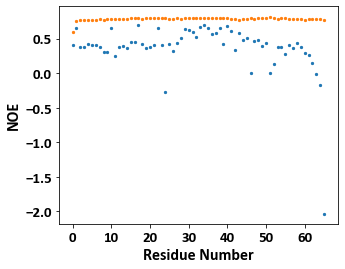

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
sub.scatter(np.array(range(len(NMR_EXP))),NMR_EXP[:,2],s=5)
sub.scatter(np.array(range(len(NMR_EXP))),FitRelaxDF['NOE'].values,s=5)
sub.set_ylabel(r'NOE',fontproperties=font_prop)
sub.set_xlabel(r'Residue Number',fontproperties=font_prop)

    #plt.xlim(25,55)
    #sub.set_xticks(np.linspace(0,150,4))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(15)

#plt.savefig('/home/dongdong/SCR/pdz.run02/Q.png',dpi=600,bbox_inches='tight')
plt.show()

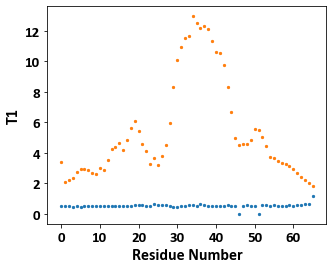

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)
leg_prop = font_manager.FontProperties(fname=font_path, size=10)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
sub.scatter(np.array(range(len(NMR_EXP))),NMR_EXP[:,0],s=5)
sub.scatter(np.array(range(len(NMR_EXP))),FitRelaxDF['T1'].values,s=5)
sub.set_ylabel(r'T1',fontproperties=font_prop)
sub.set_xlabel(r'Residue Number',fontproperties=font_prop)

    #plt.xlim(25,55)
    #sub.set_xticks(np.linspace(0,150,4))
    #ax.set_yticklabels([0,0.5,1,2])
    #leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
    #leg.get_frame().set_linewidth(0.0)
    #leg.get_frame().set_alpha(0.1)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(15)

#plt.savefig('/home/dongdong/SCR/pdz.run02/Q.png',dpi=600,bbox_inches='tight')
plt.show()